### Imports

In [5]:
import random
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

import nltk
# English:
from nltk.stem import WordNetLemmatizer
# Arabic
from nltk.stem.isri import ISRIStemmer
import contractions

from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Dropout
from keras.models import load_model

from tkinter import *

In [6]:
lemmatizer = WordNetLemmatizer()

In [7]:
data_file = open("helwan_data.json", encoding='utf-8', errors= 'ignore').read()
intents = json.loads(data_file)

### Preprocessing

In [8]:
words = []
classes = []
documents = []
ignore_words = ["?","!",".",","]

In [9]:
for intent in intents["intents"]:
    for pattern in intent["patterns"]:
        expanded_pattern = contractions.fix(pattern)

        tokens = nltk.word_tokenize(expanded_pattern.lower())
        
        # Add to word list
        words.extend(tokens)
        
        documents.append((tokens, intent["tag"]))

        if intent["tag"] not in classes:
            classes.append(intent["tag"])
            
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_words]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open("words.pkl","wb"))
pickle.dump(classes, open("classes.pkl","wb"))

### Training

In [10]:
training = []
output_empty = [0] * len(classes)

for doc in documents:
    bag = []
    pattern_words = doc[0]
    
    pattern_words = [lemmatizer.lemmatize(word) for word in pattern_words]
  
    for w in words:
        if w in pattern_words:
            bag.append(1)
        else:
            bag.append(0)

    
    output_row = list(output_empty)
    output_row[classes.index(doc[1])]=1
    
    training.append(bag + output_row)

In [11]:
random.shuffle(training)
training=np.array(training)

In [12]:
train_x = training[:, :len(words)]
train_y = training[:, len(words):]
print("train data created")

train data created


In [13]:
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation="softmax"))


sgd = SGD(learning_rate=0.01,momentum = 0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer = sgd, metrics=["accuracy"]) 
save_model = model.fit(np.array(train_x), np.array(train_y),epochs=200, batch_size = 5, verbose=1,validation_split = 0.2)
model.save("chatbot_mode.h5", save_model)

C:\Users\j\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.0224 - loss: 3.5616 - val_accuracy: 0.1200 - val_loss: 3.4643
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1211 - loss: 3.3748 - val_accuracy: 0.1000 - val_loss: 3.3774
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1336 - loss: 3.2259 - val_accuracy: 0.1800 - val_loss: 3.3030
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1369 - loss: 3.0630 - val_accuracy: 0.1600 - val_loss: 3.2137
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1908 - loss: 3.0230 - val_accuracy: 0.1800 - val_loss: 3.0926
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2528 - loss: 2.7075 - val_accuracy: 0.3000 - val_loss: 2.9308
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2828 - loss: 2.5605 - val_accuracy: 0.3600 - val_loss: 2.7671
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3700 - loss: 2.4175 - val_accuracy: 0.3400 - 

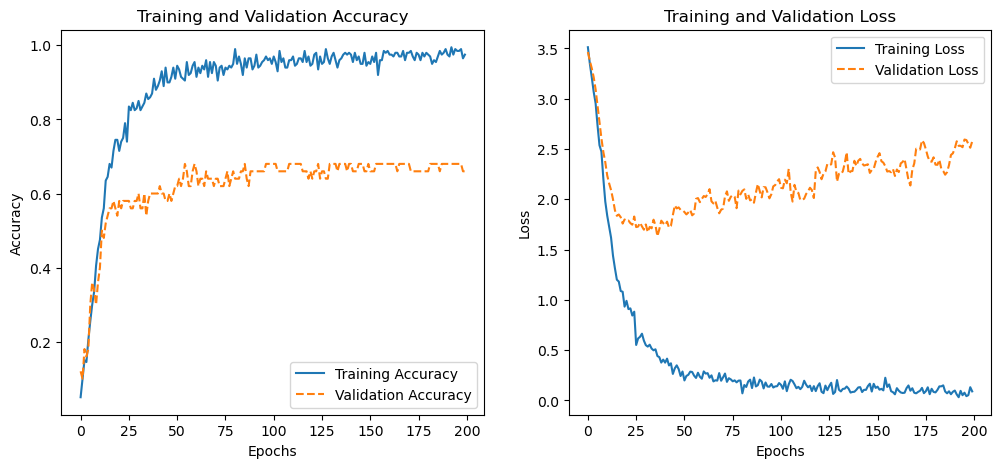

In [14]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(save_model.history['accuracy'], label="Training Accuracy")
plt.plot(save_model.history.get('val_accuracy', []), label="Validation Accuracy", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")


# Loss plot
plt.subplot(1,2,2)
plt.plot(save_model.history['loss'], label="Training Loss")
plt.plot(save_model.history['val_loss'], label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.show()

In [15]:
words= pickle.load(open('words.pkl', 'rb'))
classes= pickle.load(open('classes.pkl', 'rb'))

model = load_model('chatbot_mode.h5')

### Functions

In [16]:
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence.lower())
    sentence_words = [lemmatizer.lemmatize(word) for word in sentence_words]
    return sentence_words
    
def bag_of_words(sentence):
    sentence_words = clean_up_sentence(sentence)
    bag = [0]*len(words)
    
    for w in sentence_words:
        for i, word in enumerate(words):
            if word ==w:
                bag[i]=1
                
    return np.array(bag)

def predict_class(sentence):
    bow = bag_of_words(sentence)
    res = model.predict(np.array([bow]))[0]
   
    ERROR_THRESHOLD = 0.15
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
   
    return_list = []
    
    for r in results:
        return_list.append({'intent':classes[r[0]], 'probability':str(r[1])})
    return return_list
    

def get_response(intents_list, intents_json):
 #   if not intents_list:  # If the model finds no matching intent
  #      return "I'm not sure I understand. Can you rephrase or ask something else?"
    
    if intents_list[0]['intent'] == 'no_match':
        return "I'm sorry, but I'm not trained to understand that yet."
    
    tag = intents_list[0]['intent']
    list_of_intents = intents_json['intents']
    
    for i in list_of_intents:
        if i['tag'] == tag:
            result = random.choice(i['responses'])
            break
    
    return result


def send_message():
    message = entry.get()
    if message.strip() != "":
        entry.delete(0, END)
        response = ""
        ints = predict_class(message)
        res = get_response(ints, intents)
        response += res + "\n"
        lines = response.split("\n")
        formatted_response = "\n".join(lines)
        label2.config(text=response)

### Trial

In [6]:
print('Hello! I am HUChat. How can I help you today? Type "quit" to exit.')

while True:
    user_input = input('')
    
    # Exit condition
    if user_input.lower() == 'quit':
        print("Goodbye! Have a great day!")
        break
    

    ints = predict_class(user_input)
    

    if not ints:
       print("I'm sorry, but I'm not trained to understand that yet.")
       continue  # Skip the response generation and ask again


    response = get_response(ints, intents)
    print(response)

Hello! I am HUChat. How can I help you today? Type "quit" to exit.


 location


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
You can find Helwan University’s location on Google Maps through this link: https://maps.app.goo.gl/WpTVATyuxYQE31r3A


 quit


Goodbye! Have a great day!


#### Trial GUI

In [ ]:
window = Tk()
window.geometry("1000x1000")
window.title("HUchat")
window.config(background="#a68a64")

# Labels for text output
label1 = Label(window,
               text="HUchat",
               font=('Arial', 20, 'bold'),
               fg='#d1a88c',
               bg='#6d4c41',
               relief=FLAT,
               padx=20,
               pady=20)
label1.place(x=455, y=120)

label3 = Label(window,
               text= "Hello! I am HUChat. How can I help you today?",
               font=('Arial', 20, 'bold'),
               fg='#d1a88c',
               bg='#6d4c41',
               relief=FLAT,
               padx=0,
               pady=0)
label3.place(x=100, y=350)

# Entry widget for user input
entry = Entry(window,
              font=("Arial", 20),
              fg="#282d36",
              bg="white",
              width=30)
entry.place(x=100, y=400)

button = Button(window,
                text="Send",
                command=send_message,
                font=("Arial", 10),
                fg="#e6d5c6",  
                bg="#8a5a44",  
                activeforeground="#d4a276",  
                activebackground="#705d56",
               width = 20,
               height = 2)
button.place(x=600, y=400)

label2 = Label(window,
               text="",
               font=('Arial', 15, 'bold'),
               fg='#4f4230',
               bg='#a68a64',
               relief=FLAT,
               padx=0,
               pady=0, justify=LEFT,
               wraplength=600)
label2.place(x=100, y=450)

button1 = Button(window,
                 text="Quit",
                 command=window.destroy,
                 font=("Arial", 10),
                 fg="#e6d5c6",
                 bg="#8a5a44",
                 activeforeground="#d4a276",  
                activebackground="#705d56",
                 width = 20,
                 height = 2)
button1.place(x=455, y=725)

window.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
